### Условие задания

Имеется 1066 наблюдений над различными участками поверхности Солнца. 

Известны: 
* класс участка
* размер максимального пятна на участке
* распределение пятен
* относительная активность
* тип эволюции участка
* код активности в предыдущие 24 часа
* площадь участка
* сложность участка в наблюдавшемся прошлом
* сложность участка при последнем повороте вокруг Солнца
* число вспышек на каждом участке в течение 24 часов после начала наблюдения (вспышки разделены на три категории по мощности)

Задача: построить модель, по свойствам участка предсказывающую суммарное число вспышек в последующие 24 часа, дать интерпретацию коэффициентов.

In [96]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats.distributions import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [97]:
data = pd.read_excel('solar_flares.xlsx')
data.head()

,modified Zurich class,largest spot size,spot distribution,Activity,Evolution,Previous 24 hour flare activity code,Historically-complex,Did region become historically complex on this pass across the sun's disk,Area,C-class flares production by this region in the following 24 hours (common flares),M-class flares production by this region in the following 24 hours (moderate flares),X-class flares production by this region in the following 24 hours (severe flares)
0,H,A,X,reduced,growth,nothing as big as an M1,yes,yes,small,0,0,0
1,D,R,O,reduced,growth,nothing as big as an M1,yes,no,small,0,0,0
2,C,S,O,reduced,growth,nothing as big as an M1,yes,no,small,0,0,0
3,H,R,X,reduced,no growth,nothing as big as an M1,yes,yes,small,0,0,0
4,H,S,X,reduced,decay,nothing as big as an M1,yes,no,small,0,0,0


Изменим названия столбцов на более компактные.

In [98]:
new_names_dict = {
    'modified Zurich class': 'clss',
    'largest spot size': 'spot_size',
    'spot distribution ': 'spot_distr',
    'Activity': 'activity',
    'Evolution': 'evolution',
    'Previous 24 hour flare activity code': 'last_day_activity',
    'Historically-complex ': 'hist_complex',
    'Did region become historically complex on this pass across the sun\'s disk': 'become_hist_complex',
    'Area': 'area',
    'C-class flares production by this region in the following 24 hours (common flares)': 'c_flares_num',
    'M-class flares production by this region in the following 24 hours (moderate flares)': 'm_flares_num',
    'X-class flares production by this region in the following 24 hours (severe flares)': 'x_flares_num'
}

data = data.rename(columns=new_names_dict)

Так как необходимо построить модель для предсказания суммарного числа вспышек, то просуммируем число вспышек разных категорий, а исходные столбцы удалим.

In [99]:
data['flares_num'] = data.c_flares_num + data.m_flares_num + data.x_flares_num 
data = data.drop(columns=['c_flares_num', 'm_flares_num', 'x_flares_num'])

Посмотрим на распределение целевой переменной.

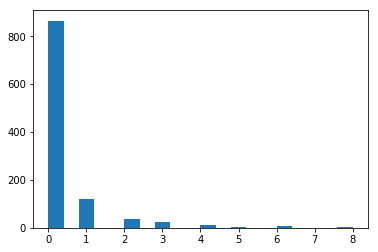

In [5]:
plt.hist(data['flares_num'], bins=20);

Большинство значений равны 0. Никакие объекты не похожи на явные выбросы, поэтому на этом этапе также ничего не удаляем. Так как переменная - счетчик, то можно попробовать приблизить ее распределение распределением Пуассона. Но сначала проверим, равны ли мат ожидание и дисперсия данных.

In [261]:
print('mean =', data['flares_num'].mean())
print('variace =', data['flares_num'].var())

mean = 0.3527204502814259
variace = 0.8989456438443252


Дисперсия больше матожидания. Поэтому вместо распределения Пуассона будем использовать отрицательное биномиальное распределение.

Посмотрим на остальные данные.

In [79]:
data.nunique()

clss                   6
spot_size              6
spot_distr             4
activity               2
evolution              3
last_day_activity      3
hist_complex           2
become_hist_complex    2
area                   2
flares_num             8
dtype: int64

Все переменные, кроме целевой, категориальные. Посмотрим на таблицы сопряженности для каждой переменной с целевой переменной.

In [81]:
pd.crosstab(data['clss'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
clss,,,,,,,,
B,136,10,1,0,0,0,0,0
C,182,21,3,4,0,1,0,0
D,165,45,15,9,4,0,1,0
E,51,15,7,8,4,3,5,2
F,20,10,8,2,3,0,0,0
H,311,18,2,0,0,0,0,0


In [82]:
pd.crosstab(data['spot_size'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
spot_size,,,,,,,,
A,145,36,17,9,4,2,1,2
H,21,4,1,1,0,0,0,0
K,16,10,7,4,6,0,3,0
R,193,19,4,1,0,1,0,0
S,356,40,6,8,1,1,2,0
X,134,10,1,0,0,0,0,0


In [84]:
pd.crosstab(data['spot_distr'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
spot_distr,,,,,,,,
C,16,5,4,2,4,1,3,0
I,133,46,22,13,5,0,2,2
O,405,50,8,8,2,3,1,0
X,311,18,2,0,0,0,0,0


In [85]:
pd.crosstab(data['activity'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
activity,,,,,,,,
reduced,768,92,17,15,6,2,2,0
unchanged,97,27,19,8,5,2,4,2


In [87]:
pd.crosstab(data['evolution'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
evolution,,,,,,,,
decay,72,2,1,1,0,1,0,0
growth,396,63,21,12,4,2,6,1
no growth,397,54,14,10,7,1,0,1


In [88]:
pd.crosstab(data['last_day_activity'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
last_day_activity,,,,,,,,
more activity than one M1,12,5,3,0,1,1,3,0
nothing as big as an M1,844,113,31,23,9,3,3,2
one M1,9,1,2,0,1,0,0,0


In [89]:
pd.crosstab(data['hist_complex'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
hist_complex,,,,,,,,
no,314,59,23,17,9,3,5,1
yes,551,60,13,6,2,1,1,1


In [90]:
pd.crosstab(data['become_hist_complex'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
become_hist_complex,,,,,,,,
no,740,112,35,23,11,4,6,2
yes,125,7,1,0,0,0,0,0


In [91]:
pd.crosstab(data['area'], data['flares_num'])

flares_num,0,1,2,3,4,5,6,8
area,,,,,,,,
big,10,5,4,3,2,0,3,0
small,855,114,32,20,9,4,3,2


Среди признаков нет констант, на этом этапе ничего не удаляем.

Исследуем, все ли признаки более значимы для предсказания целевой переменной, чем константа. Для сравнения вложенных моделей будем использовать критерий отношения правдоподобия.

In [6]:
def lr_test(ll_min, ll_max):
    """
    likeliood-ratio test for nested models
    
    ll_min, ll_max - loglikelihood of models
    
    output: p-value
    
    """
    G = 2 * (ll_max - ll_min)
    return chi2.sf(G, 1)

In [7]:
model_0 = smf.glm('flares_num ~ 1', data, family=sm.families.NegativeBinomial())
result_0 = model_0.fit()

In [8]:
single_term = pd.DataFrame(columns=['feature', 'p-val'])

for col in data.drop(columns = ['flares_num']).columns:
    model = smf.glm('flares_num ~ ' + col, data=data, family=sm.families.NegativeBinomial())
    result = model.fit()
    single_term = single_term.append({'feature': col, 
                                      'p-val': lr_test(result_0.llf, result.llf)}, ignore_index=True)
    
single_term.sort_values(by='p-val')

,feature,p-val
0,clss,2.779208e-62
2,spot_distr,3.457728e-50
1,spot_size,5.613417e-41
3,activity,5.820153e-25
6,hist_complex,1.104043e-16
8,area,1.209732e-12
7,become_hist_complex,1.898762e-10
5,last_day_activity,1.008093e-09
4,evolution,1.844161e-04


Да, гипотеза о том, что коэффициент при признаке равен нулю, уверенно отвергается для всех признаков. На этом этапе ничего не удаляем.

### Poisson vs Negative Binomial

Известно, что распределение Пуассона зависит от одного параметра $\mu$, а отрицательное биномиальное распределение - от двух параметров $\mu$ и $\alpha$, фукнции плотности вероятности для них имеют вид

$$f_{P}(y | \mu) =  \frac{e^{- \mu} \mu^{y}}{y!} $$

$$f_{NB}(y | \mu, \alpha) = \frac{\Gamma(y + \alpha^{-1})}{\Gamma(y + 1) \Gamma(\alpha^{-1})} \Big( \frac{\alpha^{-1}}{\alpha^{-1} + \mu} \Big)^{\alpha^{-1}} \Big( \frac{\mu}{\mu + \alpha^{-1}} \Big)^{y} $$

При $\alpha^{-1} \to 0$ отрицательное биномиальное распределение стремится к распределению Пуассона. Модель, приближающая данные распределением Пуассона, вложена в модель, приближающую отрицательным биномиальным распределением. Обучим обе модели на всех признаках и проверим нулевую гипотезу о том, что $\alpha^{-1} = 0$ с помощью критерия отношения правдоподобия.

In [9]:
formula = 'flares_num ~ clss + spot_distr + spot_size + activity + hist_complex + area + \
    become_hist_complex + last_day_activity + evolution'
model_p = smf.glm(formula, data=data, family=sm.families.Poisson())
result_p = model_p.fit()

model_nb = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
result_nb = model_nb.fit()

lr_test(result_p.llf, result_nb.llf)

1.2671707581882752e-24

Нулевая гипотеза уверенно отвергается. Тогда данные, действительно, лучше описываются отрицательным биномиальным распределением.

### Model 1

Еще раз обучим модель на всех признаках и посмотрим на результаты.

In [10]:
formula = 'flares_num ~ clss + spot_distr + spot_size + activity + hist_complex + area + \
    become_hist_complex + last_day_activity + evolution'
model_1 = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
result_1 = model_1.fit()

result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             flares_num   No. Observations:                 1066
Model:                            GLM   Df Residuals:                     1045
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -667.47
Date:                Tue, 28 Apr 2020   Deviance:                       640.37
Time:                        11:52:23   Pearson chi2:                 1.22e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -20.8773   1.32e+04     -0.002      0.999   -2.58e+04    2.58e+04
clss[T.C]                                       19.2580   1.32e+04      0.001      0.999   -2.58e+04    2.58e+04
clss[T.D]                                       19.7610   1.32e+04      0.002      0.999   -2.58e+04    2.58e+04
clss[T.E]                                       20.5663   1.32e+04      0.002      0.999   -2.58e+04    2.58e+04
clss[T.F]                                       20.2097   1.32e+04      0.002      0.999   -2.58e+04    2.58e+04
clss[T.H]                                        8.8607   6586.358      0.001      0.999   -1.29e+04    1.29e+04
spot_distr[T.I]                                 -0.0420      0.308     -0.136      0.892      -0.646       0.562
spot_distr[T.O]                                 -0.4453      0.342     -1.302      0.193      -1.116       0.225
spot_distr[T.X]                                  8.8607   6586.358      0.001      0.999   -1.29e+04    1.29e+04
spot_size[T.H]                                  -0.5050      0.447     -1.130      0.259      -1.381       0.371
spot_size[T.K]                                   0.6472      0.290      2.231      0.026       0.079       1.216
spot_size[T.R]                                  -0.5805      0.249     -2.332      0.020      -1.068      -0.093
spot_size[T.S]                                  -0.0505      0.192     -0.263      0.792      -0.427       0.326
spot_size[T.X]                                  18.1026   1.32e+04      0.001      0.999   -2.58e+04    2.58e+04
activity[T.unchanged]                            0.2886      0.178      1.625      0.104      -0.059       0.637
hist_complex[T.yes]                              0.1621      0.177      0.915      0.360      -0.185       0.510
area[T.small]                                    0.3261      0.393      0.830      0.407      -0.444       1.097
become_hist_complex[T.yes]                      -0.1014      0.452     -0.225      0.822      -0.986       0.784
last_day_activity[T.nothing as big as an M1]    -0.2207      0.321     -0.689      0.491      -0.849       0.407
last_day_activity[T.one M1]                     -0.3000      0.563     -0.533      0.594      -1.404       0.804
evolution[T.growth]                              0.5103      0.390      1.309      0.190      -0.254       1.274
evolution[T.no growth]                           0.3657      0.387      0.945      0.344      -0.392       1.124
================================================================================================================
"""

In [11]:
VIF = pd.DataFrame(columns=['features', 'VIF Factor'])
variables = result_1.model.exog
for i in range(1, variables.shape[1]):
    VIF = VIF.append({'features':result_1.params.index[i] , 
                      'VIF Factor': variance_inflation_factor(variables, i)}, ignore_index=True)
VIF

,features,VIF Factor
0,clss[T.C],85.868082
1,clss[T.D],94.564535
2,clss[T.E],45.063252
3,clss[T.F],22.214838
4,clss[T.H],inf
5,spot_distr[T.I],8.819123
6,spot_distr[T.O],14.487722
7,spot_distr[T.X],inf
8,spot_size[T.H],1.147363
9,spot_size[T.K],1.918383


Некоторые столбцы сильно скореллированы. Видимо, из-за этого и возникают большие дисперсии. Попробуем выяснить, какие это столбцы. Большие значения VIF имеют стоблцы $clss = H, spot\_distr = X, spot\_size = X$. Псмотрим на таблицы сопряженности признаков $clss, spot\_distr, spot\_size$.

In [12]:
pd.crosstab(data['clss'], data['spot_distr'])

spot_distr,C,I,O,X
clss,,,,
B,0,15,132,0
C,0,21,190,0
D,7,114,118,0
E,20,43,32,0
F,8,30,5,0
H,0,0,0,331


In [13]:
pd.crosstab(data['clss'], data['spot_size'])

spot_size,A,H,K,R,S,X
clss,,,,,,
B,0,0,0,0,2,145
C,24,3,1,93,90,0
D,93,8,14,59,65,0
E,46,6,18,3,22,0
F,20,3,12,1,7,0
H,33,7,1,62,228,0


Действительно, столбцы $clss = H$ и $spot\_distr = X$, а также столбцы $clss = B$ и $spot\_size = X$ полностью (почти полностью) совпадают. Заменим два одинаковых столбца на один. При этом в данных ничего не поменяется, а матрица признаков перестанет быть вырожденной. Сделаем это следующим образом: объединим "проблемные" классы в исходных признаках с какими-то другими, и добавим дополнительный бинарный признак - индикатор того, что объект принадлежит иходному "проблемному" классу. Можно объединять с тем классом, который мы убираем при dummy-кодировании, тогда в матрице признаков совсем ничего не поменяется.

In [100]:
data['clss_X'] = (data['clss'] == 'H')
data['clss'][data['clss'] == 'H'] = 'B'
data['spot_distr'][data['spot_distr'] == 'X'] = 'C'

In [101]:
data['clss_B'] = (data['clss'] == 'B')
data['clss'][data['clss'] == 'B'] = 'C'
data['spot_size'][data['spot_size'] == 'X'] = 'A'

### Model 2

Посмотрим, что получилось

In [24]:
formula = 'flares_num ~ clss + clss_X + clss_B + spot_distr + spot_size + activity + hist_complex + area + \
    become_hist_complex + last_day_activity + evolution'
model_2 = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
result_2 = model_2.fit()

result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             flares_num   No. Observations:                 1066
Model:                            GLM   Df Residuals:                     1046
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -667.62
Date:                Tue, 28 Apr 2020   Deviance:                       640.66
Time:                        12:07:50   Pearson chi2:                 1.23e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.6161      0.639     -2.528      0.011      -2.869      -0.363
clss[T.D]                                        0.5016      0.226      2.216      0.027       0.058       0.945
clss[T.E]                                        1.3067      0.263      4.977      0.000       0.792       1.821
clss[T.F]                                        0.9502      0.331      2.873      0.004       0.302       1.598
clss_X[T.True]                                  -0.3628      0.572     -0.634      0.526      -1.484       0.759
clss_B[T.True]                                  -1.1720      0.381     -3.077      0.002      -1.919      -0.425
spot_distr[T.I]                                 -0.0415      0.308     -0.135      0.893      -0.646       0.563
spot_distr[T.O]                                 -0.4440      0.342     -1.298      0.194      -1.114       0.226
spot_size[T.H]                                  -0.5072      0.447     -1.135      0.256      -1.383       0.369
spot_size[T.K]                                   0.6458      0.290      2.227      0.026       0.077       1.214
spot_size[T.R]                                  -0.5835      0.249     -2.345      0.019      -1.071      -0.096
spot_size[T.S]                                  -0.0557      0.191     -0.291      0.771      -0.431       0.320
activity[T.unchanged]                            0.2887      0.178      1.625      0.104      -0.059       0.637
hist_complex[T.yes]                              0.1621      0.177      0.914      0.360      -0.185       0.510
area[T.small]                                    0.3259      0.393      0.829      0.407      -0.444       1.096
become_hist_complex[T.yes]                      -0.1013      0.452     -0.224      0.823      -0.986       0.784
last_day_activity[T.nothing as big as an M1]    -0.2201      0.321     -0.687      0.492      -0.848       0.408
last_day_activity[T.one M1]                     -0.2986      0.563     -0.530      0.596      -1.402       0.805
evolution[T.growth]                              0.5094      0.390      1.307      0.191      -0.255       1.273
evolution[T.no growth]                           0.3642      0.387      0.941      0.347      -0.394       1.122
================================================================================================================
"""

In [25]:
VIF = pd.DataFrame(columns=['features', 'VIF Factor'])
variables = result_2.model.exog
for i in range(1, variables.shape[1]):
    VIF = VIF.append({'features':result_2.params.index[i] , 
                      'VIF Factor': variance_inflation_factor(variables, i)}, ignore_index=True)
VIF

,features,VIF Factor
0,clss[T.D],2.041855
1,clss[T.E],1.866311
2,clss[T.F],1.594470
3,clss_X[T.True],17.480636
4,clss_B[T.True],4.923306
5,spot_distr[T.I],8.818813
6,spot_distr[T.O],14.485641
7,spot_size[T.H],1.145891
8,spot_size[T.K],1.917427
9,spot_size[T.R],2.099921


Теперь никакие признаки так сильно не коррелируют, и дисперсии лежат в нормальном диапазоне. Попробуем удалить наименее значимые признаки и посмотрим, как изменится модель.

Категориальные признаки лучше оценивать в совокупности.


In [26]:
columns_list = ['clss + clss_X + clss_B', 'spot_distr + clss_X', 'spot_size + clss_B', 'activity',
                'hist_complex', 'area', ' become_hist_complex', 'last_day_activity', 'evolution']

p_vals = pd.DataFrame(columns=['feature', 'p-val'])

for column in columns_list:
    formula = "flares_num ~ "
    for c in columns_list:
        if column != c:
            formula += c + ' + '
    formula = formula[:-3]
    model = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
    result = model.fit()
    
    p_vals = p_vals.append({'feature': column,
                  'p-val': lr_test(result.llf, result_2.llf)}, ignore_index=True)

p_vals.sort_values(by='p-val')

,feature,p-val
0,clss + clss_X + clss_B,1.067089e-07
2,spot_size + clss_B,1.557112e-04
1,spot_distr + clss_X,3.067927e-02
3,activity,1.058262e-01
8,evolution,1.218536e-01
4,hist_complex,3.580818e-01
5,area,4.087673e-01
7,last_day_activity,4.725189e-01
6,become_hist_complex,8.218916e-01


### Model 3

In [27]:
formula = 'flares_num ~ clss + clss_X + clss_B + spot_distr + spot_size + activity'
model_3 = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
result_3 = model_3.fit()

result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             flares_num   No. Observations:                 1066
Model:                            GLM   Df Residuals:                     1053
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -670.04
Date:                Tue, 28 Apr 2020   Deviance:                       645.51
Time:                        12:10:29   Pearson chi2:                 1.25e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.0392      0.376     -2.767      0.006      -1.775      -0.303
clss[T.D]                 0.4874      0.223      2.186      0.029       0.050       0.924
clss[T.E]                 1.2290      0.255      4.824      0.000       0.730       1.728
clss[T.F]                 0.7784      0.318      2.449      0.014       0.156       1.401
clss_X[T.True]           -0.4458      0.525     -0.849      0.396      -1.475       0.583
clss_B[T.True]           -1.1368      0.376     -3.025      0.002      -1.873      -0.400
spot_distr[T.I]           0.0226      0.283      0.080      0.936      -0.531       0.576
spot_distr[T.O]          -0.4012      0.324     -1.238      0.216      -1.036       0.234
spot_size[T.H]           -0.4805      0.443     -1.085      0.278      -1.349       0.388
spot_size[T.K]            0.5393      0.250      2.161      0.031       0.050       1.028
spot_size[T.R]           -0.5247      0.242     -2.170      0.030      -0.998      -0.051
spot_size[T.S]           -0.0237      0.189     -0.125      0.900      -0.393       0.346
activity[T.unchanged]     0.2942      0.165      1.785      0.074      -0.029       0.617
=========================================================================================
"""

In [28]:
lr_test(result_3.llf, result_2.llf)

0.027713379012448355

На уровне значимости 0.01 полученная модель не хуже предыдущей. Так что остановимся на сокращенном наборе признаков. Посмотрим на их значимость.

In [29]:
columns_list = ['clss + clss_X + clss_B', 'spot_distr + clss_X', 'spot_size + clss_B', 'activity']

p_vals = pd.DataFrame(columns=['feature', 'p-val'])

for column in columns_list:
    formula = "flares_num ~ "
    for c in columns_list:
        if column != c:
            formula += c + ' + '
    formula = formula[:-3]
    model = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
    result = model.fit()
    
    p_vals = p_vals.append({'feature': column,
                  'p-val': lr_test(result.llf, result_3.llf)}, ignore_index=True)

p_vals.sort_values(by='p-val')

,feature,p-val
0,clss + clss_X + clss_B,3.418664e-07
2,spot_size + clss_B,2.993036e-04
1,spot_distr + clss_X,2.122700e-02
3,activity,7.692482e-02


Все оставшиеся признаки значимы на уровне 0.1, если рассматривать закодированные столбцы категориальных переменных в совокупности. Попробуем добавить конкатенации этих признаков и посмотреть, улучшится ли модель.

In [30]:
pair_list = [' + clss * spot_distr + clss_B * spot_distr', ' + clss * spot_size + clss_X * spot_size', 
            ' + clss * activity + clss_X * activity + clss_B * activity',
             ' + spot_distr * spot_size', ' + spot_distr * activity', ' + spot_size * activity']

pairwize = pd.DataFrame(columns=['pair', 'p-val'])

formula = 'flares_num ~ clss + clss_X + clss_B + spot_distr + spot_size + activity'
for pair in pair_list:
    model = smf.glm(formula + pair, data=data, family=sm.families.NegativeBinomial())
    result = model.fit()
    
    pairwize = pairwize.append({'pair': pair,
                    'p-val': lr_test(result_3.llf, result.llf)}, ignore_index=True)

pairwize    

,pair,p-val
0,+ clss * spot_distr + clss_B * spot_distr,0.045617
1,+ clss * spot_size + clss_X * spot_size,0.000003
2,+ clss * activity + clss_X * activity + clss_...,0.052136
3,+ spot_distr * spot_size,0.001502
4,+ spot_distr * activity,0.726496
5,+ spot_size * activity,0.016343


Наиболее значимое улучшение модели произошло при добавлении конкатенации $clss * spot\_size$ (также не следует забывать, что clss\_X - это, фактически, еще один столбец закодированного признака $clss$, и его тоже нужно конкатенировать. Столбец $clss\_B$ общий для переменных $clss$ и $spot\_size$, поэтому его не конкатенируем.

Добавим конкатенацию признаков в модель и посмотрим на результаты.

In [33]:
formula = 'flares_num ~ spot_distr + activity + clss_B + clss * spot_size + clss_X * spot_size'
model_4 = smf.glm(formula, data=data, family=sm.families.NegativeBinomial())
result_4 = model_4.fit()

result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             flares_num   No. Observations:                 1066
Model:                            GLM   Df Residuals:                     1037
Model Family:        NegativeBinomial   Df Model:                           28
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -659.01
Date:                Tue, 28 Apr 2020   Deviance:                       623.44
Time:                        12:14:21   Pearson chi2:                 1.18e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.2757      0.812     -2.803      0.005      -3.867      -0.684
spot_distr[T.I]                  -0.2386      0.303     -0.788      0.431      -0.832       0.355
spot_distr[T.O]                  -0.6069      0.342     -1.776      0.076      -1.277       0.063
activity[T.unchanged]             0.2689      0.170      1.583      0.114      -0.064       0.602
clss_B[T.True]                    0.2866      0.774      0.370      0.711      -1.230       1.803
clss[T.D]                         1.9538      0.769      2.542      0.011       0.447       3.460
clss[T.E]                         2.8352      0.773      3.666      0.000       1.319       4.351
clss[T.F]                         2.3706      0.821      2.888      0.004       0.762       3.979
spot_size[T.H]                    1.7840      1.373      1.299      0.194      -0.908       4.476
spot_size[T.K]                    3.5758      1.433      2.496      0.013       0.767       6.384
spot_size[T.R]                    1.1769      0.786      1.497      0.135      -0.364       2.718
spot_size[T.S]                    1.3562      0.762      1.779      0.075      -0.138       2.850
clss_X[T.True]                   -0.8228      0.855     -0.963      0.336      -2.498       0.853
clss[T.D]:spot_size[T.H]        -23.6666   1.83e+04     -0.001      0.999   -3.58e+04    3.58e+04
clss[T.E]:spot_size[T.H]         -1.9499      1.493     -1.306      0.192      -4.877       0.977
clss[T.F]:spot_size[T.H]         -2.3706      1.828     -1.297      0.195      -5.953       1.212
clss[T.D]:spot_size[T.K]         -2.6355      1.486     -1.774      0.076      -5.548       0.276
clss[T.E]:spot_size[T.K]         -3.6615      1.488     -2.460      0.014      -6.579      -0.744
clss[T.F]:spot_size[T.K]         -3.4060      1.520     -2.241      0.025      -6.385      -0.427
clss[T.D]:spot_size[T.R]         -1.8806      0.860     -2.187      0.029      -3.566      -0.195
clss[T.E]:spot_size[T.R]        -24.2293    2.9e+04     -0.001      0.999   -5.69e+04    5.68e+04
clss[T.F]:spot_size[T.R]         -1.0331      1.651     -0.626      0.531      -4.268       2.202
clss[T.D]:spot_size[T.S]         -1.3604      0.814     -1.672      0.095      -2.955       0.234
clss[T.E]:spot_size[T.S]         -1.5591      0.843     -1.850      0.064      -3.211       0.093
clss[T.F]:spot_size[T.S]         -1.6025      1.016     -1.577      0.115      -3.594       0.389
clss_X[T.True]:spot_size[T.H]   -21.7073   1.98e+04     -0.001      0.999   -3.89e+04    3.88e+04
clss_X[T.True]:spot_size[T.K]   -23.4990   5.24e+04     -0.000      1.000   -1.03e+05    1.03e+05
clss_X[T.True]:spot_size[T.R]    -1.8084      1.290     -1.402      0.161      -4.337       0.720
clss_X[T.True]:spot_size[T.S]    -1.0966     

In [37]:
VIF = pd.DataFrame(columns=['features', 'VIF Factor'])
variables = result_4.model.exog
for i in range(1, variables.shape[1]):
    VIF = VIF.append({'features':result_4.params.index[i] , 
                      'VIF Factor': variance_inflation_factor(variables, i)}, ignore_index=True)
VIF

,features,VIF Factor
0,spot_distr[T.I],8.679350
1,spot_distr[T.O],14.513700
2,activity[T.unchanged],1.353672
3,clss_B[T.True],11.709642
4,clss[T.D],9.722155
5,clss[T.E],5.516033
6,clss[T.F],4.011870
7,spot_size[T.H],9.796230
8,spot_size[T.K],45.728008
9,spot_size[T.R],8.567120


In [34]:
lr_test(result_3.llf, result_4.llf)

2.6339550924999356e-06

Модель стала значимо лучше, но дисперсии некоторых признаков принимают очень большие значения. При этом показатели VIF для всех признаков не слишклм большие. Видимо, дело в чем-то другом. Посмотрим на объекты, для которых значения этих признаков равны 1.

In [42]:
print(np.sum(data['flares_num'][np.logical_and((data['clss'] == 'D').values,
                                               (data['spot_size'] == 'H').values)]))
print(np.sum(data['flares_num'][np.logical_and((data['clss'] == 'E').values,
                                               (data['spot_size'] == 'R').values)]))
print(np.sum(data['flares_num'][np.logical_and((data['clss_X'] == True).values,
                                               (data['spot_size'] == 'H').values)]))
print(np.sum(data['flares_num'][np.logical_and((data['clss_X'] == True).values,
                                               (data['spot_size'] == 'K').values)]))

0
0
0
0


Можно заметить, что все объекты этих категорий имеют значение целевой переменной, равное нулю. Тогда для того, чтобы значение экспоненты от линейной комбинации значений признаков с весами было близко к нулю, веса стремятся к бесконечности. То есть такое поведение связано с особенностями данных: с преобладанием в них нулевых значений целевой переменной.

Посмотрим на значимость объектов.

In [47]:
infl = result_4.get_influence()
sm_fr = infl.summary_frame()

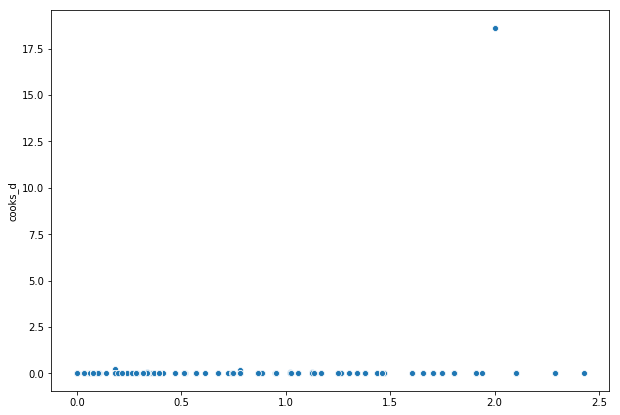

In [49]:
plt.figure(figsize=(10,7))
sns.scatterplot(result_4.fittedvalues, sm_fr.cooks_d)

Видно, что один из объектов существенно значимее остальных. Посмотрим на него.

In [50]:
data[sm_fr.cooks_d > 1]

,clss,spot_size,spot_distr,activity,evolution,last_day_activity,hist_complex,become_hist_complex,area,flares_num,clss_X,clss_B
160,C,K,O,reduced,no growth,nothing as big as an M1,yes,no,small,2,False,False


In [57]:
data[np.logical_and((data['clss'] == 'C').values, (data['spot_size'] == 'K').values)]

,clss,spot_size,spot_distr,activity,evolution,last_day_activity,hist_complex,become_hist_complex,area,flares_num,clss_X,clss_B
160,C,K,O,reduced,no growth,nothing as big as an M1,yes,no,small,2,False,False
657,C,K,C,reduced,growth,nothing as big as an M1,yes,yes,small,0,True,True


Он является единственным объектом с ненулевым значением отклика, для которого конкатенация признаков $clss$ и $spot\_size$ равна $(C, K)$. Посмотрим на значимости остальных объектов.

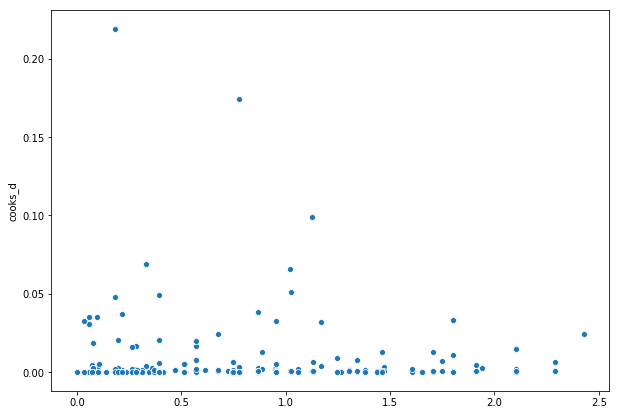

In [58]:
plt.figure(figsize=(10,7))
sns.scatterplot(result_4.fittedvalues[sm_fr.cooks_d < 1], sm_fr.cooks_d[sm_fr.cooks_d < 1])

Попробуем убрать из выборки все объекты, уровень значимости которых выше некоторого эмпирически установленного порога, и обучить модель.

In [59]:
data_crop = data[sm_fr.cooks_d < 0.1]

In [60]:
formula = 'flares_num ~ spot_distr + activity + clss_B + clss * spot_size + clss_X * spot_size'
model_5 = smf.glm(formula, data=data_crop, family=sm.families.NegativeBinomial())
result_5 = model_5.fit()

result_5.summary()

ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

Видимо, эти влиятельные наблюдения были единственными отличными от нуля значениями в каких-то классах. Так как мы применяем модель без регуляризаторов, то она неустойчива при большом числе нулевых значений целевой переменной.

Попробуем убрать попарные взаимодействия признаков и снова обучить модель.

In [102]:
formula = 'flares_num ~ clss + clss_B + clss_X + spot_size + spot_distr + activity'
model_5= smf.glm(formula, data=data_crop, family=sm.families.NegativeBinomial())
result_5 = model_5.fit()

result_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             flares_num   No. Observations:                 1061
Model:                            GLM   Df Residuals:                     1048
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -648.56
Date:                Wed, 29 Apr 2020   Deviance:                       620.29
Time:                        01:19:02   Pearson chi2:                 1.15e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.0418      0.382     -2.728      0.006      -1.790      -0.293
clss[T.D]                 0.5895      0.234      2.515      0.012       0.130       1.049
clss[T.E]                 1.2309      0.267      4.609      0.000       0.707       1.754
clss[T.F]                 0.8146      0.329      2.477      0.013       0.170       1.459
clss_B[T.True]           -1.0200      0.383     -2.665      0.008      -1.770      -0.270
clss_X[T.True]           -0.5325      0.528     -1.008      0.313      -1.568       0.502
spot_size[T.H]           -0.4276      0.442     -0.967      0.334      -1.294       0.439
spot_size[T.K]            0.4541      0.253      1.795      0.073      -0.042       0.950
spot_size[T.R]           -0.6624      0.255     -2.594      0.009      -1.163      -0.162
spot_size[T.S]           -0.0353      0.192     -0.185      0.854      -0.411       0.340
spot_distr[T.I]          -0.0332      0.283     -0.117      0.907      -0.587       0.521
spot_distr[T.O]          -0.5292      0.327     -1.621      0.105      -1.169       0.111
activity[T.unchanged]     0.3390      0.166      2.040      0.041       0.013       0.665
=========================================================================================
"""

По сравнению с моделью 3, обученной на том же наборе признаков, веса модели изменились. То есть исключение наиблее влиятельных наблюдений, действительно, имело смысл. 

Использование более простой модели на сокращенном наборе признаков не приводит к переобучению под данные. Но, в то же время, так как данных довольно мало, и большинство значений целевой переменной нулевые, то обучение на таких данных модели, скорее всего, приведет к переобучению.

Посмотрим на точность предсказания модели.

In [103]:
np.sum(data['flares_num'] == round(result_5.predict(exog=data))) / data.shape[0]

0.7270168855534709

Так как данные приближались отрицательным биномиальным распределением, а все столбцы закодированной матрицы признаков бинарные, то при увеличении значения веса при каком-то признаке на alpha предсказания откликов на объектах соответсвующего класса увеличиваются в alpha раз. Точечные оценки весов и 95% доверительные интервалы можно посмотреть в таблице.

Итоговая модель строит предсказания на суммарное число вспышек в ближайшие 24 часа по следующим признакам:
* класс участка 
* размер максимального пятна на участке
* распределение пятен
* относительная активность